We have:
$$
\nabla f = (I + \beta A) \vec s - \vec y
    = \vec s - \vec y + \beta A \vec s
$$ 
We can substitute in the partial derivatives:
$$ 
\left(\begin{matrix}
s_0 - y_0 + \beta (s_0 - s_1) \\
s_1 - y_1 + \beta (2s_1 - s_0 - s_2) \\
\vdots \\
s_N - y_N + \beta (s_N - s_{N - 1})
\end{matrix}\right) 
= \vec s - \vec y + \beta A \vec s
$$

Adding $\vec y - \vec s$ to both sides and then dividing by $\beta$ yields:
$$ 
\left(\begin{matrix}
s_0 - s_1 \\
2s_1 - s_0 - s_2 \\
\vdots \\
s_N - s_{N - 1}
\end{matrix}\right) 
= A \vec s
$$

Solving for $A$ is trivial and yields:
$$ 
A = \left(\begin{matrix}
1  & -1  &   &  &  &  &  \\
-1 & 2   & -1 &    & &     &  \\
  & -1  & 2  & -1 & &     &  \\
 & & \ddots & \ddots & \ddots & & \\
 &     & & -1 & 2  & -1 &  \\
 &     & &    & -1 & 2  & -1\\
  &  &  &  &  & -1 & 1
\end{matrix}\right) 
$$

In [1]:
import numpy as np
import scipy.sparse as sparse
import modules.tridiagonal as td
import matplotlib.pyplot as plot
import matplotlib.pyplot as plot
import modules.tridiagonal as td
import modules.image_tools as image_tools
from PIL import Image  # PIL is an image processing module

def sample_with_noise(points, vectorized_g):
  """
  Sample a function at a given set of points,
  introducing noise in the process.

  Returns a tuple of the real values of the function
  and the values with introduced noise.

  For performance reasons, this function takes in
  a vectorized version of `g`. If you want to pass
  a non vectorized function use `np.vectorize`. Eg:
  ```py
  sample_with_noise(points, np.vectorize(g))
  ```
  """
  gs = vectorized_g(points)
  ys = gs + 0.05 * np.random.randn(len(gs))

  return (gs, ys)

def p5(x):
  """
  Vectorized version of the function
  described in the pdf.
  """
  n = 5
  result = 0

  for k in range(n + 1):
    result += x**k

  return result/(n + 1)

def create_A(n):
  """
  Creates the (n+1) x (n + 1) A matrix.
  (see the latex above for it's definition)
  """
  a = 2*np.ones(n + 1)
  a[0] = 1
  a[-1] = 1

  c = -np.ones(n)
  e = -np.ones(n)

  return td.create(a, c, e)

def smooth(data, beta):
  """
  Smooth noisy data (y) by means of solving 
  a minimization problem.

  Args:
    data (numpy.array): noisy data to be smoothed (y)
    beta (float): parameter >= 0 that balances fit and smoothing

  Returns:
    numpy array of smoothed data (s)
  """
  # We need to solve for s in:
  #      (I + βA)s - y = 0
  #  <=> (I + βA)s = y
  #
  # Because A and I are tridiagonal, I + βA
  # is tridiagonal as well (linear combinations
  # of tridiagonal matrices are themselves
  # tridiagonal)
  #
  # This means we can use our existing implementation
  # of tridiagonal linear equation system solving.
  # 
  # We start by constructing 
  #   iba := I + βA
  n = len(data) - 1

  # I + βA
  iba = td.add(
    td.identity(n + 1),
    td.scale(beta, create_A(n))
  )

  data_smoothed = td.solve(*iba, data)

  return data_smoothed

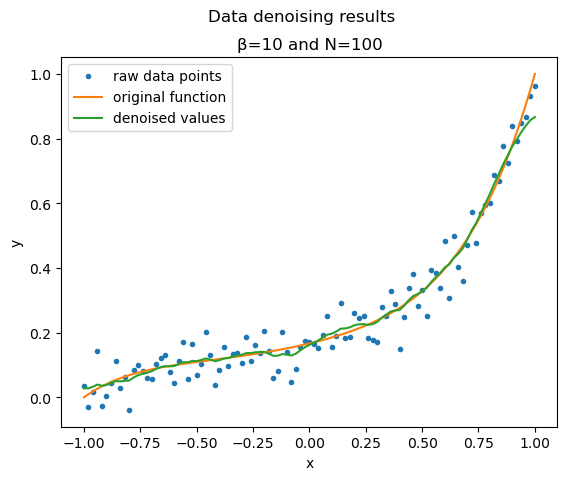

In [2]:
# Reusable function to plot the data
def plot_denoise_results(beta, N, ax):
  # Create the data
  x = np.linspace(-1, 1, num=N+1)
  g, y = sample_with_noise(x, p5)
  s = smooth(y, beta)

  ax.set_title(f"β={beta} and {N=}")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.plot(x, y, ".", label="raw data points")
  ax.plot(x, g, "-", label="original function")
  ax.plot(x, s, "-", label="denoised values")
  ax.legend()


N = 100
beta = 10

fig, ax = plot.subplots()
fig.suptitle("Data denoising results")

# Plot the data
plot_denoise_results(beta, N, ax)

We notice that finding a point where $\nabla f(s) = 0$ is the same as
finding a point where $\frac 1 \beta \nabla f(s) = \nabla \frac 1 \beta f(s) = 0$.
We can use this to our advantage, by defining $h(s) = \frac 1 \beta f(s)$ and
finding the points where $\nabla h(s) = 0$ instead. When $\beta \to \infty$, we have:
$$
\lim_{\beta \to \inf} h _\beta (s) =
\lim_{\beta \to \inf} 
  \frac 1 {2\beta} \sum_{k=0}^n (y_k - s_k)^2
 +\frac 1 2 \sum_{k=1}^n (s_k - s_{k - 1})^2
 = \frac 1 2 \sum_{k=1}^n (s_k - s_{k - 1})^2
$$

It now becomes trivial to verify that $\nabla f(s) = As$.
Looking at the value of $A$ we notice that any vector with all values
equal to some constant are solutions for this equation.
This means the result will be a constant function
(which might differ based on the linear equation solver we are using).

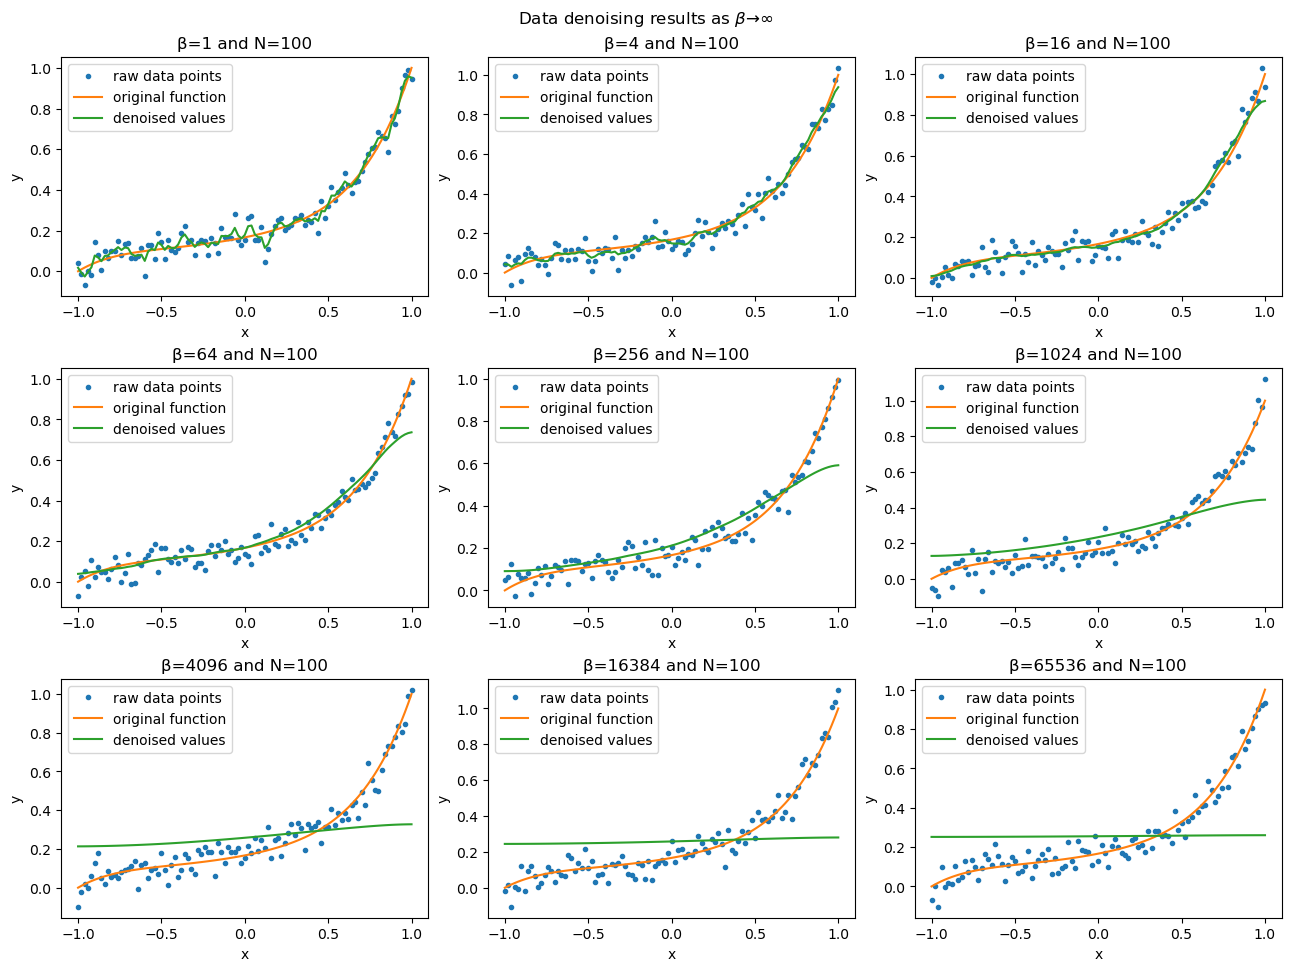

In [3]:
fig, axs = plot.subplots(
    3,
    3,
    layout="constrained",
    figsize=(12.8, 9.6)
)

fig.suptitle(r"Data denoising results as $\beta \to \infty$")

N = 100

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    plot_denoise_results(4**i, N, ax)

When $\beta \to 0$ we have:
$$
\lim_{\beta \to 0} \nabla f(s) =
\lim_{\beta \to 0} (I + \betaA)s - y = s - y
$$

This means when solving for $\nabla f(s) = 0$, we are solving
the equation $s - y = 0$, which has the solution $s = y$.
The resulting function will then be one equal to the data containing the noise.

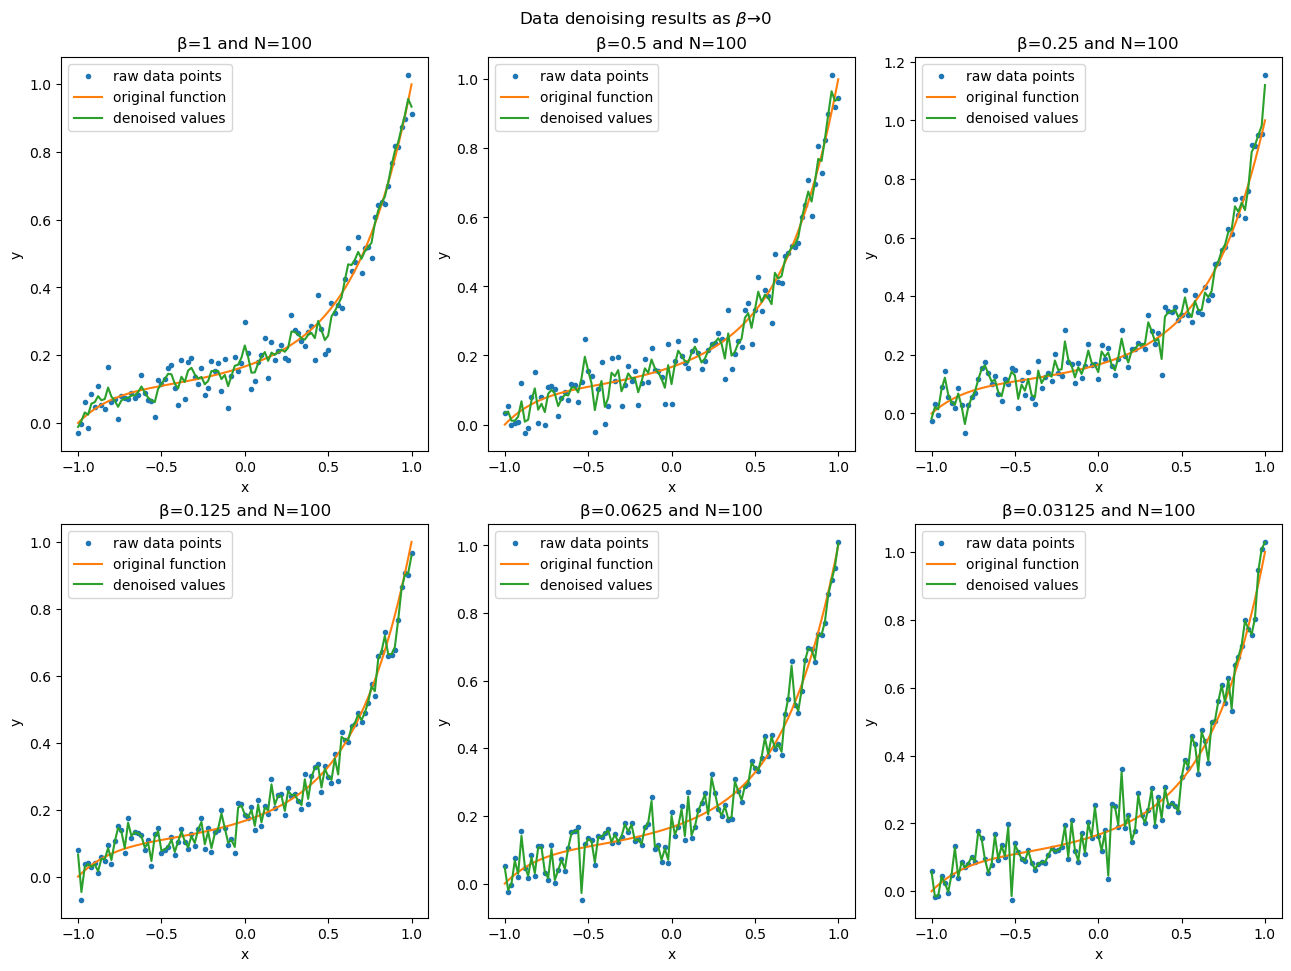

In [4]:
fig, axs = plot.subplots(
    2,
    3,
    layout="constrained",
    figsize=(12.8, 9.6)
)

fig.suptitle(r"Data denoising results as $\beta \to 0$")

N = 100

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    plot_denoise_results(2**-i, N, ax)

We know from the last lecture that picking any
$\alpha$ which satisfies $\alpha < \frac 2 {\lambda_H}$
leads to a converging sequence, where $\lambda_H$ is
the largest eigenvalue of the hessian.
Let $\lambda_A$ be the largest eigenvalue of $A$.
Our hessian is $I + \beta A$, therefore we have $Ax = \lambda_A x$ 
(for some vector $x$, from the definition of the eigenvalue for $\lambda_A$).
We can multiply by $\beta$ and add $x$ to both sides to get
$(I + \beta A)I = (1 + \beta\lambda_A) x$,
which means $1 + \beta\lambda_A$ is indeed an eigenvalue of the hessian.

Is it the biggest one though? 
Let's assume a bigger eigenvalue $\lambda_M$ exists (for the hessian).
This means that $(I + \beta A)y = \lambda_M y$ (for some vector $y$).
By distributivity we then also have $y + \beta A y = \lambda_M y$,
which makes it easy to then notice that $\frac {\lambda_M-1} \beta$
is an eigenvalue for $A$.
Earlier we have assumed that $\lambda_M > \lambda_H$,
therefore $\frac {\lambda_M - 1} \beta > \frac {\lambda_H - 1} \beta = \lambda_A$,
which would imply $\lambda_A$ is not the biggest eigenvalue for $A$,
hence a contradiction.
This let's us conclude that $\lambda_H$ is the biggest eigenvalue for the hessian,
and therefore our sequence will converge given
$\alpha < \frac 2 {\lambda _H} = \frac 2 {1 + \beta \lambda_A}$.

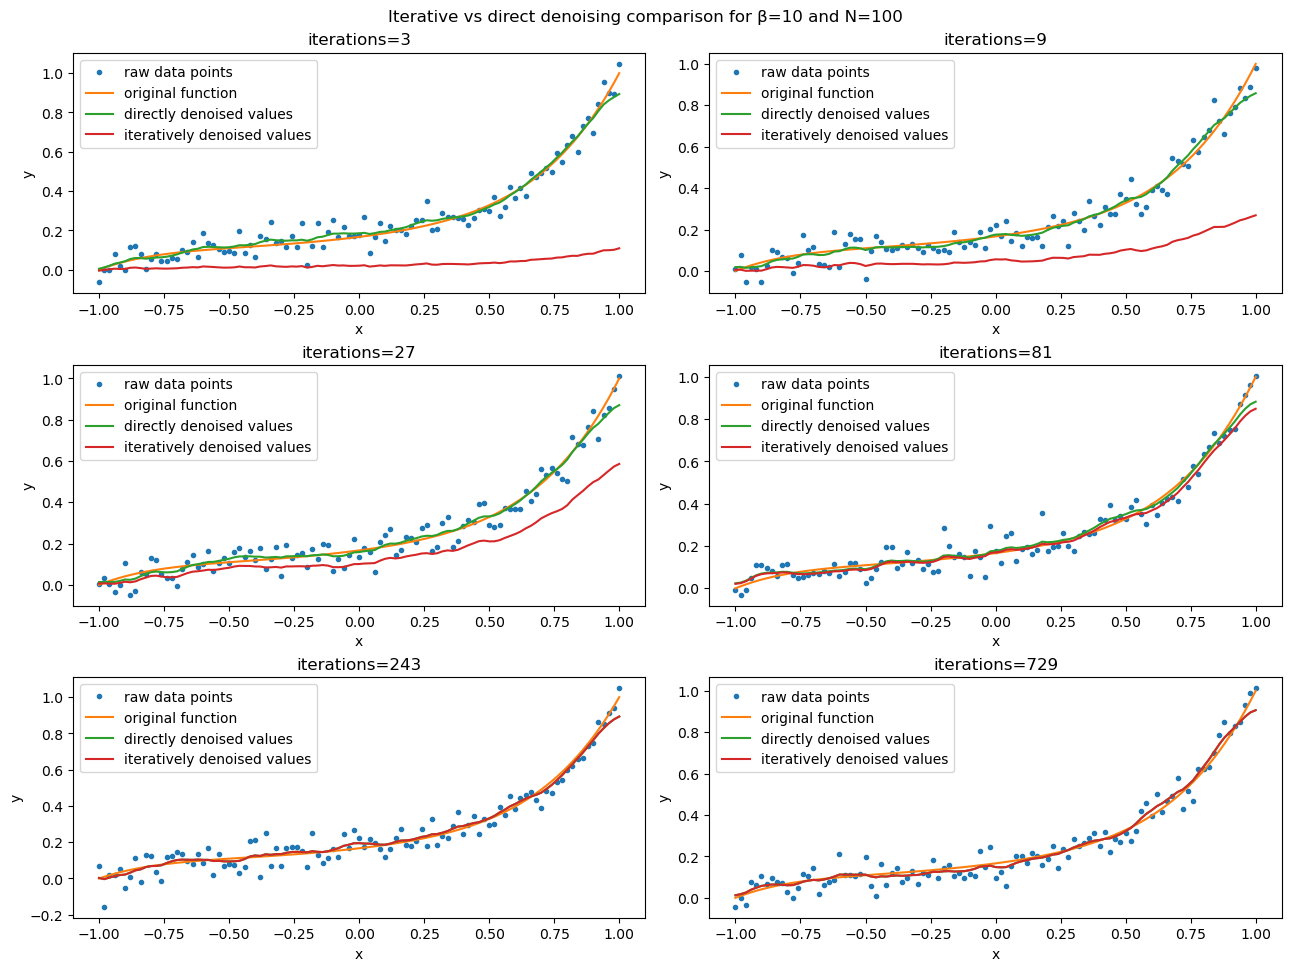

In [5]:
def smooth_iterative(data, beta, num_iterations):
  """
  Smooth noisy data (y) by means of solving a minimization problem
  iteratively with the gradient descent method.

  Args:
    data (numpy.array): of the noisy data to be smoothed (y)
    beta (float): parameter >= 0 that balances fit and smoothing
    num_iterations (int): number of gradient descent iterations (>0)

  Returns:
    numpy array of smoothed data (s)
  """

  n = len(data) - 1

  A = create_A(n)

  # Our initial eigenvalue guess
  initial_guess = np.zeros(n + 1)
  initial_guess[0] = 1

  max_eigenvalue = td.largest_eigenvalue(
    *A, 
    initial_guess,
    30
  )

  alpha = 1.5 / (1 + beta * max_eigenvalue)
  x = np.zeros(n + 1)

  for _ in range(num_iterations):
    gradient = td.multiply_vector(
      *td.add(
        td.identity(n + 1), 
        td.scale(beta, A)
      ),
      x
    ) - data
    # print(f"{alpha=}")
    # print(f"{gradient=}")
    # print(f"{x=}")
    x = x - alpha * gradient

  return x

fig, axs = plot.subplots(
    3,
    2,
    # 1,
    # 1,
    layout="constrained",
    figsize=(12.8, 9.6)
)

N = 100
beta = 10

fig.suptitle(f"Iterative vs direct denoising comparison for β={beta} and {N=}")

for i in range(len(axs.flat)):
# for _ in range(1):
  ax = axs.flat[i]
  iterations = 3**(i + 1)
  # ax = axs
  # iterations = 3 ** 5

  # Create the data
  x = np.linspace(-1, 1, num=N+1)
  g, y = sample_with_noise(x, p5)
  sd = smooth(y, beta) # Indirect
  si = smooth_iterative(y, beta, iterations) # Direct

  # Plot the data
  ax.set_title(f"{iterations=}")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.plot(x, y, ".", label="raw data points")
  ax.plot(x, g, "-", label="original function")
  ax.plot(x, sd, "-", label="directly denoised values")
  ax.plot(x, si, "-", label="iteratively denoised values")
  ax.legend()

In [6]:
def hessian(beta, nx, ny):
  """
  Compute the Hessian of the image denoising problem, given by
    `H = I + beta C^T C`.

  Args:
    beta (float): parameter >= 0 that balances fit and smoothing
    nx (int): number of pixels in x-direction
    ny (int): number of pixels in y-direction

  Returns:
    H: sparse hessian matrix (scipy.sparse.csr_array)
  """
  size = nx * ny

  b_upper_diagonal = np.ones(nx)
  b_upper_diagonal[-1] = 0

  b_main_diagonal = -np.ones(nx)
  b_main_diagonal[-1] = 0

  # We want to reuse the tridiagonal -> csr conversion code,
  # so we first define C as a tridiagonal matrix.
  tridiagonal_C = td.create(
    np.resize(b_main_diagonal, size),
    np.resize(b_upper_diagonal, size - 1),
    np.zeros(size - 1)
  )

  C = td.to_csr(*tridiagonal_C)
  H = sparse.identity(size, format="csr") + beta * (C.T @ C)

  return H

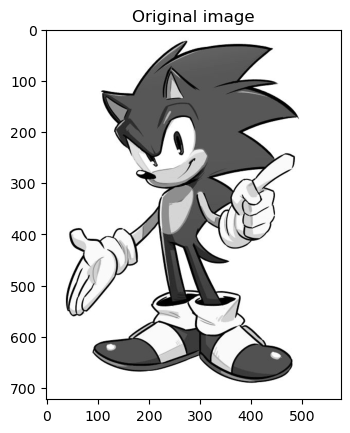

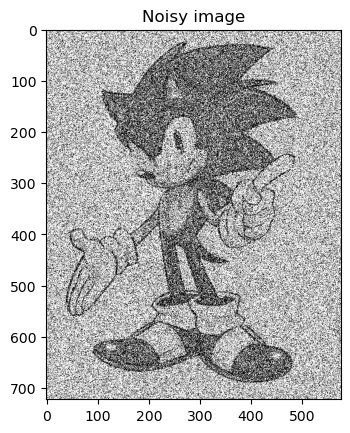

In [13]:
# Here so we can experiment with different picutres
image_name = "sonic"
image_tools.create_noisy_image("./images/", image_name + ".jpg")

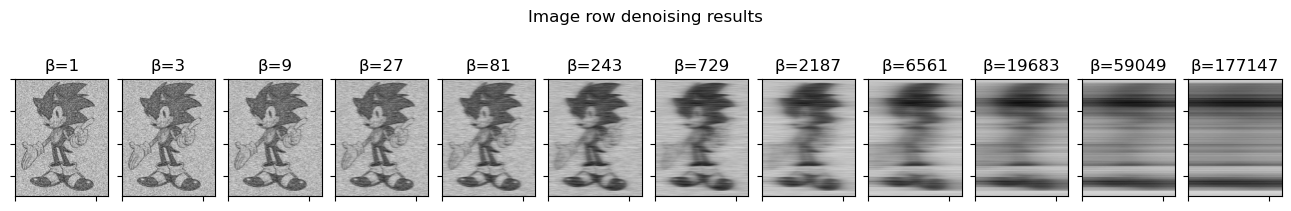

In [28]:
image = np.asarray(Image.open(f"./images/{image_name}_gray_noisy.jpg"))

fig, axs = plot.subplots(
    1,
    12,
    layout="constrained",
    figsize=(12.8, 2.4)
)

fig.suptitle("Image row denoising results")

ny, nx = image.shape
flat_image = image.flatten()
for i in range(len(axs.flat)):
  beta = 3**i
  ax = axs.flat[i]

  H = hessian(beta, nx, ny)

  smooth = sparse.linalg.spsolve(H, flat_image).reshape(image.shape)
  smooth_image = Image.fromarray(smooth.astype(np.uint8), mode="L")

  ax.set_title(f"β={beta}")

  # Turn off tick labels
  ax.set_yticklabels([])
  ax.set_xticklabels([])

  ax.imshow(smooth_image)

Finding the equation for $f$ when we want to denoise by column would simply require us to consider an image $p_c = p^T$:
$$
f(s) = \frac 1 2 \sum_{i = 1}^{N_x} \sum_{j = 1}^{N_y} (y_{j, i} - s_{j, i})^2
+ \beta \frac 1 2 \sum_{i = 1}^{N_x} \sum_{j = 2}^{N_y} (s_{j, i} - s_{j - 1, i})^2
$$

In this case, our hessian looks almost the same as the one in the original equation, with the difference being $B$ having the ones under the main diagonal instead of on top.

For the actual python implementation, we can simply transpose the image before/after the denoising:

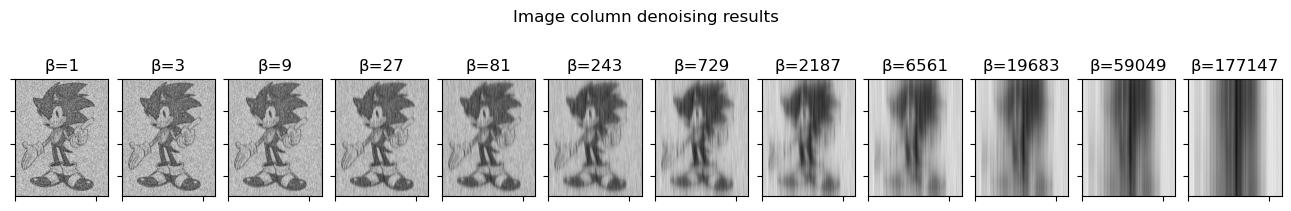

In [30]:
image = np.asarray(Image.open(f"./images/{image_name}_gray_noisy.jpg")).T

fig, axs = plot.subplots(
    1,
    12,
    layout="constrained",
    figsize=(12.8, 2.4)
)

fig.suptitle("Image column denoising results")

ny, nx = image.shape
flat_image = image.flatten()
for i in range(len(axs.flat)):
  beta = 3**i
  ax = axs.flat[i]

  H = hessian(beta, nx, ny)

  smooth = sparse.linalg.spsolve(H, flat_image).reshape(image.shape).T
  smooth_image = Image.fromarray(smooth.astype(np.uint8), mode="L")

  ax.set_title(f"β={beta}")

  # Turn off tick labels
  ax.set_yticklabels([])
  ax.set_xticklabels([])

  ax.imshow(smooth_image)